# O arquivos SEGY em Python 

Este notebook tem a intenção de demonstrar como carregar um dado sísmico 3D em Python. Posteriormente, este tipo de dado será utilizado para filtragem, demonstração de atributos sísmicos e outras aplicações. 

## Os dados utilizados

Aqui utilizaremos um conjunto de dados do Sul do Texas, do campo de exploração [Stratton](https://wiki.seg.org/wiki/Stratton_3D_survey). Este é um dado terrestre 3D pós-empilhamento. Excelente para testar algoritmos ou quaisquer outras aplicações de dados sísmicos. Estes dados foram cedido pelo [Departamento de Geologia Econômica da Universidade do Texas](https://www.beg.utexas.edu/).

## Arquivos SEGY

Este formato foi inicialmente desenvolvido pela SEG no início dos anos 70 com o objetivo de uniformizar os dados sísmicos para processamento. O formato passou por algumas revisões ao longo do tempo pelo comitê de técnico da SEG ([SEG Technical Standards](https://seg.org/Publications/SEG-Technical-Standards)). Este comitê é acionado toda vez que é identificado um problema de grande magnitude no padronamento dos mais diversos dados geofísicos, junto organizações do setor bem como da indústria. O arquivo SEGY armazena os dados de forma sequencial, como pode ser visto na figura abaixo:

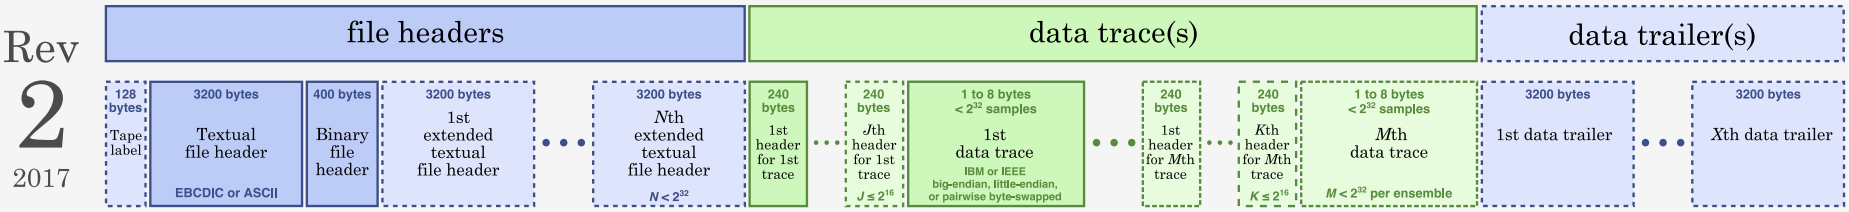

Os componentes principais de um dado SEG-Y são:
- Cabeçalho Textual
- Cabeçalho binário do arquivo
- Traços sísmicos, subdivididos por sua vez em:
  - Cabeçalho binário do traço
  - Dados do traço
- Algumas informações adicionais

No cabeçalho textual contém informações que podem ser lidas fora de qualquer software especializado. No cabeçalho binário contém informações sobre a quantidade de traços, intervalo de amostragem e outras informações relevantes. Nas informações do traço estão os valores das inlines e crosslines, posição e coordenadas. Informações adicionais, como correções e outras informações relevantes são adicionadas no fim do arquivo.

## Carregamento dos arquivos SEGY em Python

O carregamento destes dados pode ser realizado pela biblioteca [SEGYio](https://github.com/equinor/segyio), que é desenvolvida em linguagens C e Python. Além do formato SEGY, esta biblioteca tem forte interação com formato de dados do Seismic Unix. Este biblioteca é desenvolvida pela [Equinor](https://www.equinor.com.br/). 

## Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import xarray as xr

## Imprimindo o Header e as informações do arquivo

In [2]:
with segyio.open("dataset/Stratton3D.sgy",ignore_geometry=True) as f:
    print (f.text)

bytearray(b'C01 STRATTON 3D Data Set                                            
            C02                                                                 
            C03 32-bit 3-D Volume                                               
            C04                                                                 
            C05                                                                 
            C06 DATA FORMAT      : IBM FLOATING POINT                           
            C07                                                                 
            C08 HEADER PARAMETER VALUE LOCATIONS:                               
            C09 PARAMETER NAME       HEADER CONTAINING VALUE    BYTE RANGE      
            C10 ==========================================================      
            C11   LINE NUMBER          BINARY                       5 - 8       
            C12   DATA FORMAT CODE     BINARY                      25 - 26      
            C13             

In [3]:
with segyio.open("dataset/Stratton3D.sgy",iline=73,xline=77) as f:
    print (f)
    n_ilines = f.ilines
    n_cross = f.xlines
    depth = f.depth_slice[1000]
    inline = f.iline[f.ilines[102]]
    crossline = f.xline[f.xlines[101]]
    time = f.samples

SegyFile dataset/Stratton3D.sgy:
  inlines: 230 [2193745, 2181150]
  crosslines: 309 [705550, 722490]
  traces: 71070
  samples: [0.000e+00 2.000e+00 4.000e+00 ... 2.996e+03 2.998e+03 3.000e+03]
  float representation: 4-byte IBM float


In [4]:
crossline.shape

(230, 1501)

In [5]:
inline.shape

(309, 1501)

In [6]:
y = np.arange(0,230,1)
x = np.arange(0,309,1)

In [7]:
y.dtype

dtype('int64')

In [8]:
time.dtype

dtype('float64')

## Visualização dos dados sísmicos

### Visualizando uma Crossline

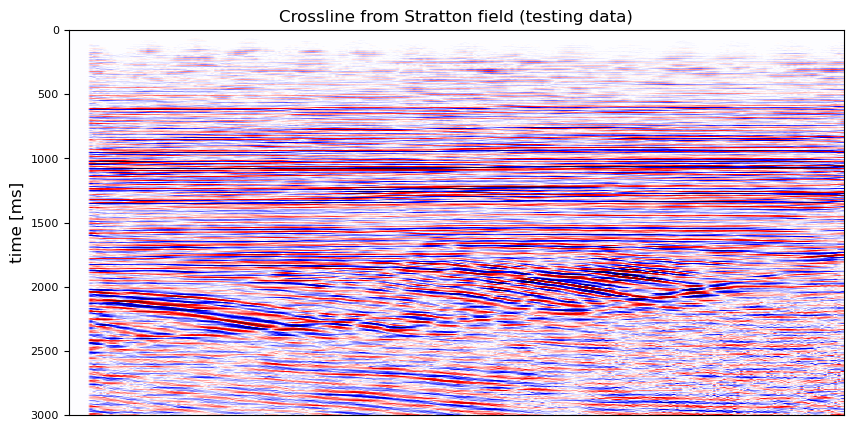

In [9]:
clip = np.percentile(np.abs(crossline), 99.0)
title_font = 15
bottom_font = 12

extent = [y.min(),y.max(),time.max(),time.min()]
plt.figure(figsize=(10, 5))
plt.title('Crossline from Stratton field (testing data)')
plt.imshow(crossline.T,aspect="auto",cmap="seismic_r", extent=extent,vmax = clip,vmin=-clip)
plt.tick_params(axis='x', which='major', bottom=False, top=True)
#plt.xlabel('trace index',size=bottom_font)
plt.ylabel('time [ms]',size=bottom_font)
plt.xticks([])
plt.yticks(size=8)

fname = 'images/stratton_test_data'
plt.savefig(fname+'.png', dpi=200)
plt.show()

In [10]:
StrattonCrossline = xr.Dataset(
    {"crossline": (("y", "time"), crossline)},
    coords={
        "y": y,
        "time": time,        
    },
)


StrattonCrossline.to_netcdf("crossline.nc")

#### Visualização de somente um traço

Podemos visualizar também somente um traço da crossline, tal como aparece nos livros. Este é uma forma de dispor o dado em torno de um valor nulo, chamado de **wiggle trace**. Consideramos a polaridade adotada pela SEG ([SEG polarity](https://wiki.seg.org/wiki/Phase_and_polarity_assessment_of_seismic_data)) para a apresentação de dados sísmicos de fase zero. Este tipo de polaridade leva em consideração a impedância acústica (IA) de um meio, na qual se uma IA cresce a polaridade é positiva (receberá as cores em azul ou preta) enquanto uma polaridade negativa representará um descréscimo da IA (representado pela cor vermelha ou branca). 

OBS.: A polaridade Europeia é o contrário disso.

*Polaridade positiva em azul e negativa em vermelho* :

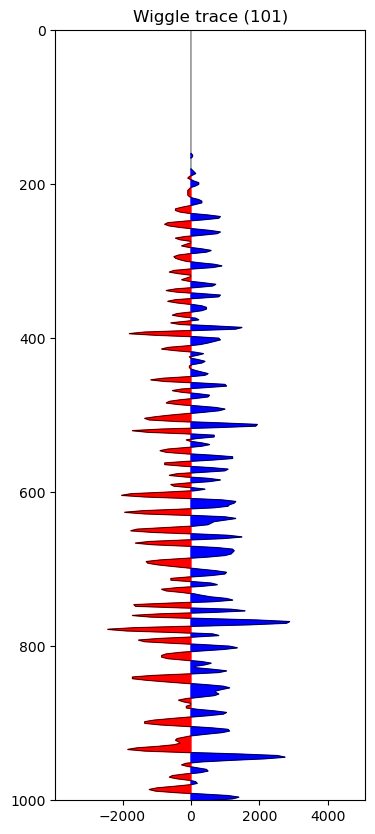

In [11]:
plt.figure(figsize=(4, 10))
plt.title('Wiggle trace (101)')
plt.plot(crossline[110], time, c="k",linewidth=0.5)
plt.fill_betweenx(time, 0.0, crossline[110], where=crossline[110] > 0.0, interpolate=True, color="b")
plt.fill_betweenx(time, 0.0, crossline[110], where=crossline[110] < 0.0, interpolate=True, color="r")
plt.ylim(1000.0, 0)
plt.show()

### Visualizando uma Inline

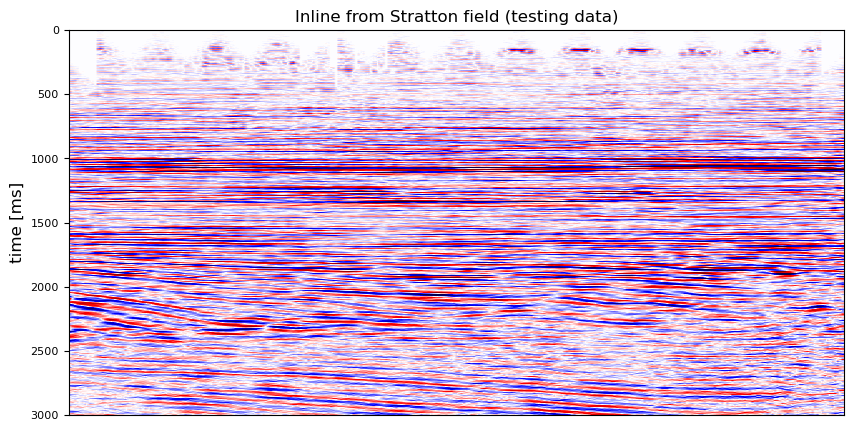

In [12]:
clip = np.percentile(np.abs(inline), 99.0)
title_font = 15
bottom_font = 12

extent = [x.min(),x.max(),time.max(),time.min()]
plt.figure(figsize=(10, 5))
plt.title('Inline from Stratton field (testing data)')
plt.imshow(inline.T,aspect="auto",cmap="seismic_r", extent=extent,vmax = clip,vmin=-clip)
plt.tick_params(axis='x', which='major', bottom=False, top=True)
#plt.xlabel('trace index',size=bottom_font)
plt.ylabel('time [ms]',size=bottom_font)
plt.xticks([])
plt.yticks(size=8)


fname = 'images/stratton_test_data_inline'
plt.savefig(fname+'.png', dpi=200)
plt.show()

In [13]:
StrattonInline = xr.Dataset(
    {"inline": (("x", "time"), inline)},
    coords={
        "x": x,
        "time": time,        
    },
)

StrattonInline.to_netcdf("inline.nc")

O mesmo vale para a inline...

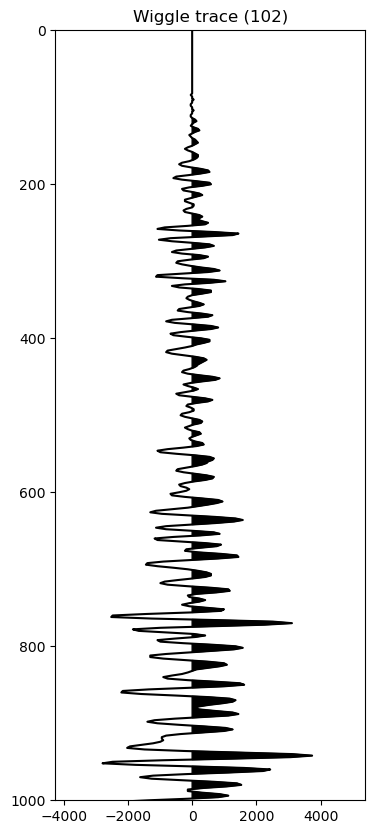

In [14]:
plt.figure(figsize=(4, 10))
plt.title('Wiggle trace (102)')
plt.plot(inline[150], time, c="k")
plt.fill_betweenx(time, 0.0, inline[150], where=inline[150] > 0.0, interpolate=True, color="k")
plt.ylim(1000.0, 0)
plt.show()

### Plotando uma depth slice

Como estamos com um dado 3D, podemos ver também um slice em tempo do cubo sísmico. Este é um tipo de dado que vemos as inlines e as crosslines em um determinado tempo arbitrário, que é uma escolha do intérprete para analisar alguma estrutura. 

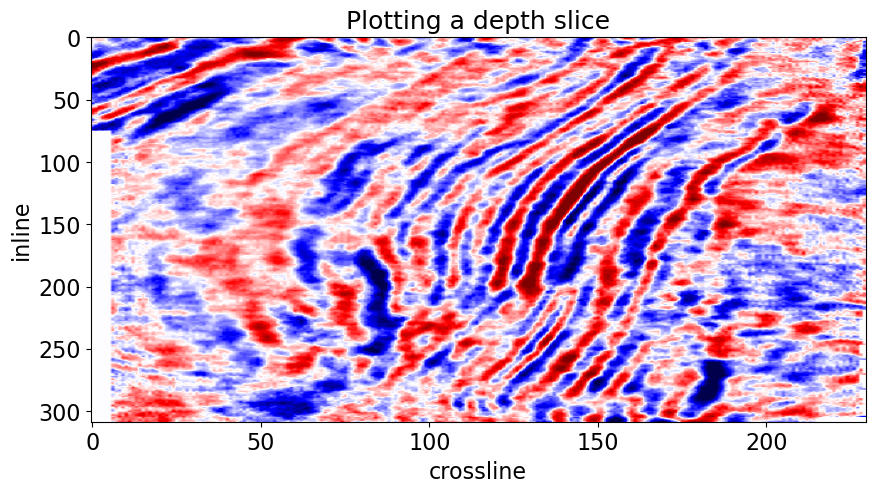

In [15]:
clip = np.percentile(np.abs(depth), 99.0)
title_font = 18
bottom_font = 16

plt.figure(figsize=(10, 5))
plt.title('Plotting a depth slice',size=title_font)
plt.imshow(depth,aspect="auto",cmap="seismic_r",vmax = clip,vmin=-clip)
plt.xlabel('crossline',size=bottom_font)
plt.ylabel('inline',size=bottom_font)
plt.xticks(size=bottom_font)
plt.yticks(size=bottom_font)
plt.show()